# Анализ продаж компьютерных игр

В нашем распоряжении данные интернет-магазина "Стримчик", который продает компьютерные игры по всему миру, включающие информацию о названиях и продажах игр, оценки пользователей и экспертов, а также жанры и платформы. <br>
**Задача:** Выявить определяющие успешность игры закономерности и построить прогноз на 2017 год.<br>
**Ход работы:** <br>
После открытия файла, необходимо проверить данные на пропуски, дупликаты и ошибки, по возможности избавимся от них. Добавим столбец с суммарными продажами.<br>
Теперь можно приступать к анализу обработанных данных, который пройдет в несколько этапов:<br>
- Определим актуальный период
- Выявим потенциально прибыльные платформы
- Посмотрим влияние отзывов пользователей и критиков на продажи
- Выявим самые прибыльные жанры
- Составим портреты пользователя каждого региона (Северная Америка, Европа и Япония)
- Проверим гипотезы: 1) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; 2) Средние пользовательские рейтинги жанров Action и Sports разные. 

## Выгрузка данных

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from scipy import stats as st

In [5]:
import warnings

In [6]:
import seaborn as sns

In [7]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Полученные данные состоят из 11 столбцов и 16715 строк, некоторые столбцы имеют пропуски.

## Предобработка данных

In [9]:
#Приводим названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [10]:
#Проверим столбец с названиями игр на пропуски
data['name'].isna().sum()

2

In [11]:
data['name'] = data['name'].fillna('не определено')
data[data['name'] == 'не определено']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,не определено,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,не определено,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [12]:
data = data.loc[~(data['name'] == 'не определено')]

Строк с пропусками мало, в них много данных пропущено, поэтому их удаление не повлияет на исследования.

In [13]:
#Проверим столбец с годами выпуска игр на пропуски
data['year_of_release'].isna().sum()

269

In [14]:
warnings.filterwarnings('ignore')

In [15]:
# Удалим пропуски
data = data.dropna(subset=['year_of_release'])

In [16]:
data['year_of_release'].isna().sum()

0

In [17]:
# Изменим тип данных на "int"
data['year_of_release'] = data['year_of_release'].astype('int')

In [18]:
data['genre'].isna().sum()

0

In [19]:
len(data)

16444

In [20]:
data['critic_score'].describe()

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [21]:
# Узнаем кол-во не определенных пользовательских оценок
len(data.loc[data['user_score'] == 'tbd'])

2376

Таких данных достаточно много, поэтому их удаление повлияет на результат исследования, поэтому заполним их как nan

In [22]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

In [23]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [24]:
data['user_score'] = data['user_score'].astype('float64')

In [25]:
data['user_score'].describe()

count    7463.000000
mean        7.126330
std         1.499447
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

In [26]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [27]:
# Заполним пропуски в столбце с рейтингом на заглушку "не определен"
data['rating'] = data['rating'].fillna('не определен')

In [28]:
data['rating'].unique()

array(['E', 'не определен', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [29]:
# Создадим новый столбец с суммарными продажами
data['total_sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1)

In [30]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,не определен,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,не определен,31.38


In [31]:
# Проверим данные на явные дупликаты
data.duplicated().sum()

0

In [32]:
# Проверим дупликаты в связке: Название игры + Платформа + Год выпуска
data.duplicated(subset = ['name', 'platform', 'year_of_release'] ).sum()

1

In [33]:
data = data.drop_duplicates(subset = ['name', 'platform', 'year_of_release'])

In [34]:
data.duplicated(subset = ['name', 'platform', 'year_of_release'] ).sum()

0

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


Во время предобработки данных мы избавились от пропусков, дупликатов и ошибок,так же  изменили названия столбцов и заменили тип данных в столбцах с годом выпуска игры и с пользовательской оценкой. Для удобства добавили столбец с суммарными продажами. 

## Исследовательский анализ данных

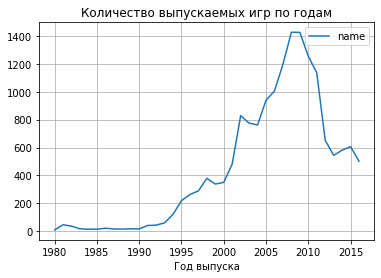

In [36]:
# Посмотрим сколько игр выпускалось в разные года
data.groupby(['year_of_release']).agg({'name':'count'}).plot(grid=True)
plt.title('Количество выпускаемых игр по годам')
plt.xlabel('Год выпуска')
plt.show()

Примерно в период с 2005 по 2011 год игр выпускалось больше всего, больше 1000 штук ежегодно. Скорее всего это связано с стремительным развитием технологий. 

In [37]:
data.groupby(['platform']).agg({'total_sales': 'sum'}).describe()

,total_sales
count,31.000000
mean,284.334194
std,343.953517
min,0.030000
25%,22.150000
50%,200.040000
75%,301.205000
max,1233.560000


Посчитаем платформы с наибольшими продажами, такие где суммарные продажи выше 303 млн

In [38]:
group_data = data.groupby(['platform']).agg({'total_sales': 'sum'}).sort_values(by='total_sales', ascending=False)
group_data.head(10)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [39]:
# Выделим платформы с наибольшими продажами
group_data = group_data[group_data['total_sales'] > 303]
group_data

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88


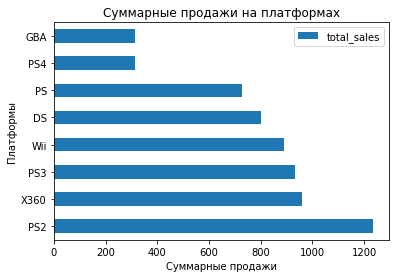

In [40]:
group_data.plot(kind='barh')
plt.title('Суммарные продажи на платформах')
plt.xlabel('Суммарные продажи')
plt.ylabel('Платформы')
plt.show()

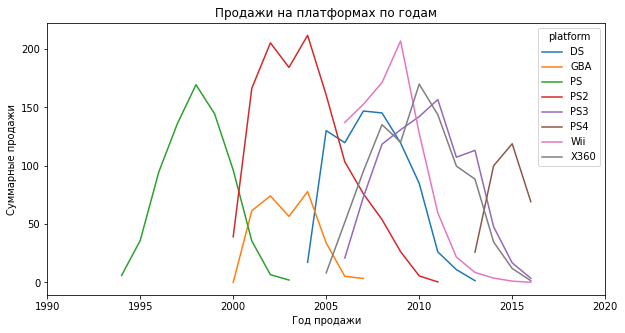

In [41]:
# Построим распределение суммарных продаж по годам у наиболее прибыльных платформ
( data.query('platform in @group_data.index')
 .pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum')
 .plot(figsize=(10,5)) )
plt.xlim(1990, 2020)
plt.title('Продажи на платформах по годам')
plt.xlabel('Год продажи')
plt.ylabel('Суммарные продажи')
plt.show()

Самые большие продажи были на таких платформа, как PS2, Х360 и Wii, наименьшие на GBA.

По графикам видно, что в среднем жизненный цикл платформы составляет около 10 лет, тогда примем за наш актуальный период 2012-2016 гг

In [42]:
data = data.loc[data['year_of_release'] > 2011]

In [43]:
len(data)

2885

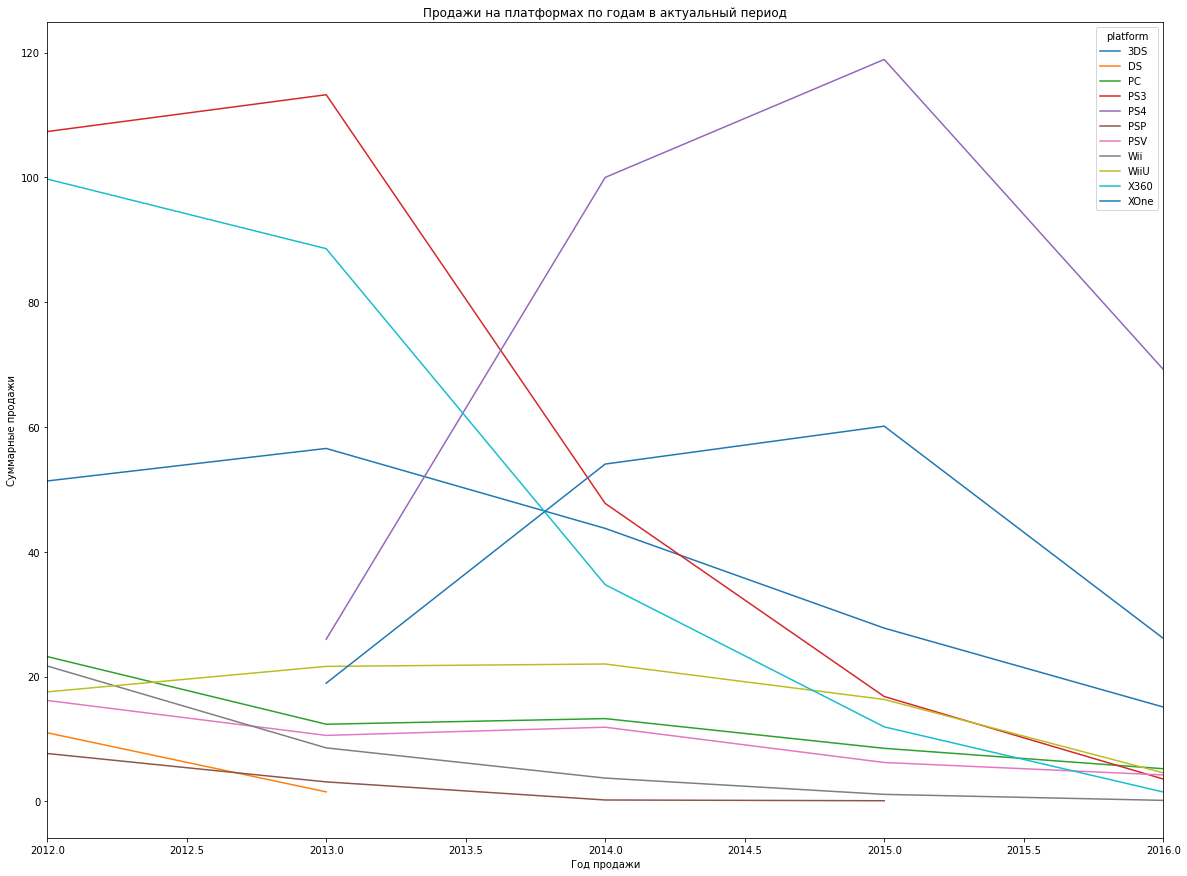

In [44]:
data.pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc='sum').plot(figsize=(20,15))
plt.xlim(2012, 2016)
plt.title('Продажи на платформах по годам в актуальный период')
plt.xlabel('Год продажи')
plt.ylabel('Суммарные продажи')
plt.show()

По графику можно предположить, что продажи на платформах PS3 и X360 идут на упадок, а XOne и PS4 растут и являются потенциально прибыльными. Платформа 3DS через некоторое время также пойдет на упадок. Остальные платформы теряют свою актуальность.

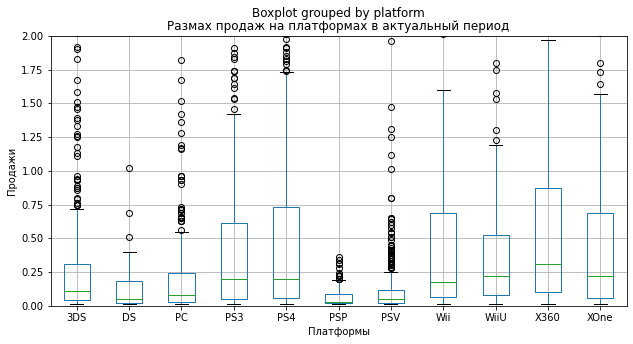

In [45]:
data.boxplot(column=['total_sales'], by='platform', figsize=(10,5))
plt.title('Размах продаж на платформах в актуальный период')
plt.ylim(0,2)
plt.xlabel('Платформы')
plt.ylabel('Продажи')
plt.show()

Самые большие медианные продажи у таких платформ, как X360, WiiU и XOne, что значит, что продажи на этих платформах стабильно высокие. Самые низкие на DS  и PSP.

Посмотрим, как влияют отзывы пользователей и критиков на продажи.

In [46]:
# Возьмем данные о платформе PS4
data_corrPS4 = data[data['platform'] == 'PS4']

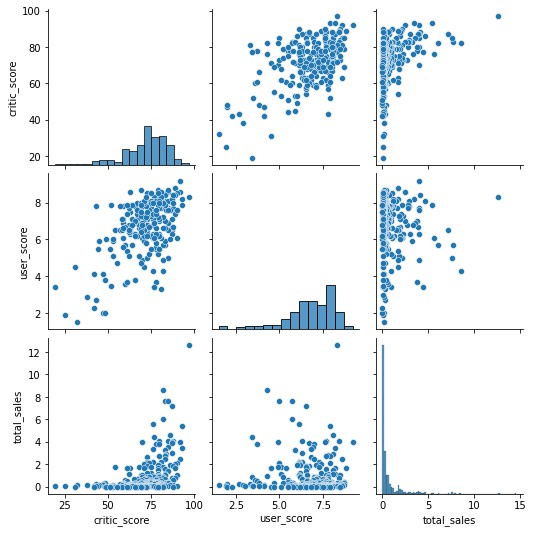

In [47]:
sns.pairplot(data_corrPS4[['critic_score', 'user_score', 'total_sales']])
plt.show()

In [48]:
data_corrPS4[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000


Продажи на платформе PS4 умеренно зависят от оценки критиков, а от оценки пользователей слабо.

In [49]:
# Возьмем данные о платформе X360
data_corrX360 = data[data['platform'] == 'X360']

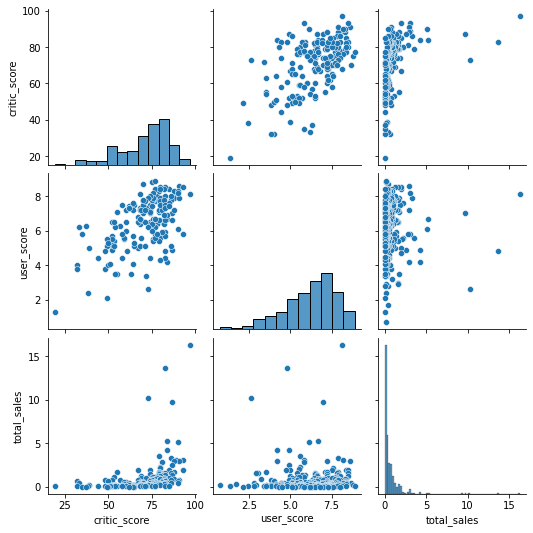

In [50]:
sns.pairplot(data_corrX360[['critic_score', 'user_score', 'total_sales']])
plt.show()

In [51]:
data_corrX360[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557352,0.360573
user_score,0.557352,1.000000,0.006164
total_sales,0.360573,0.006164,1.000000


Зависимость продаж на платформе Х360 от оценки критиков умеренная, от оценки пользователей не зависят.

In [52]:
# Возьмем данные о платформе PS3
data_corrPS3 = data[data['platform'] == 'PS3']

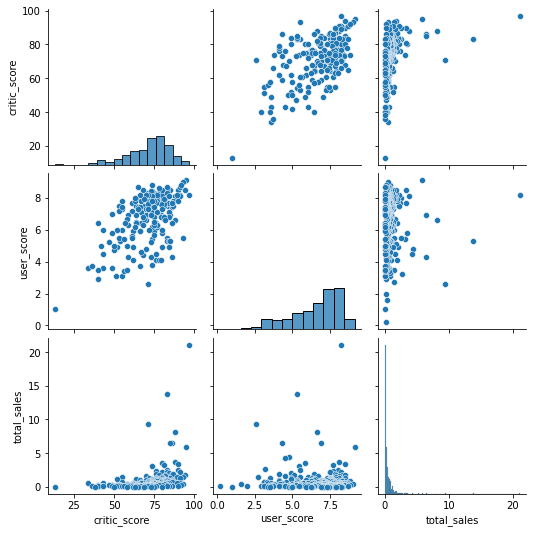

In [53]:
sns.pairplot(data_corrPS3[['critic_score', 'user_score', 'total_sales']])
plt.show()

In [54]:
data_corrPS3[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.544510,0.334152
user_score,0.544510,1.000000,-0.006206
total_sales,0.334152,-0.006206,1.000000


Зависимость прадаж на платформе PS3 от оценок такая же как и на платформе Х360

Можем предположить, что продажи на платформах слабо зависят от оценок критиков и пользователей.

In [55]:
# Сгруппируем данные по жанрам
data.groupby(['genre']).agg({'total_sales':'sum'})

,total_sales
genre,
Action,441.12
Adventure,29.43
Fighting,44.49
Misc,85.04
Platform,61.00
Puzzle,4.89
Racing,53.50
Role-Playing,192.80
Shooter,304.73


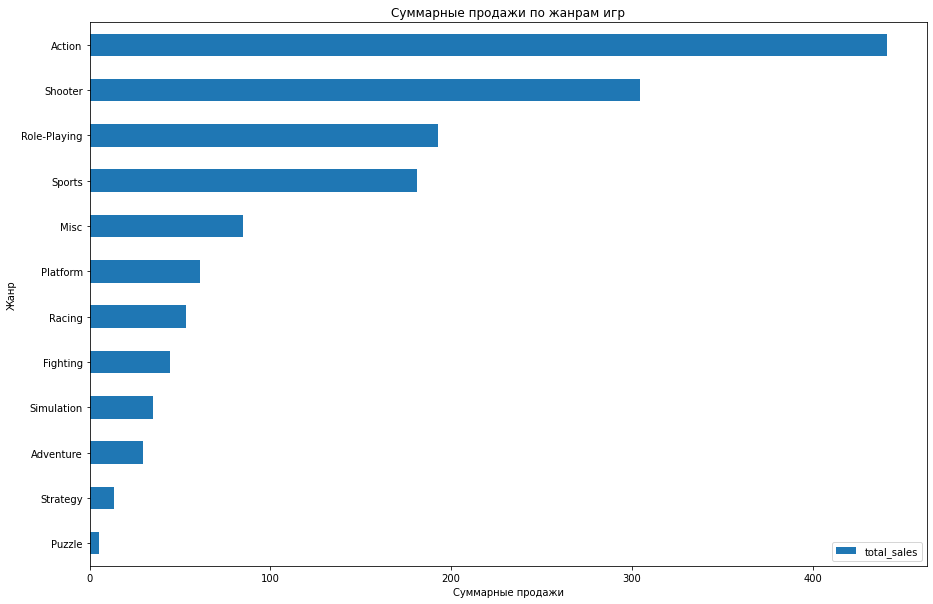

In [56]:
data.groupby(['genre']).agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending = True).plot(kind='barh', figsize=(15,10))
plt.title('Суммарные продажи по жанрам игр')
plt.xlabel('Суммарные продажи')
plt.ylabel('Жанр')
plt.show()

Игры жанра экшн и шутер являются самыми продаваемыми, пазлы и стратегия самые малопопулярные.

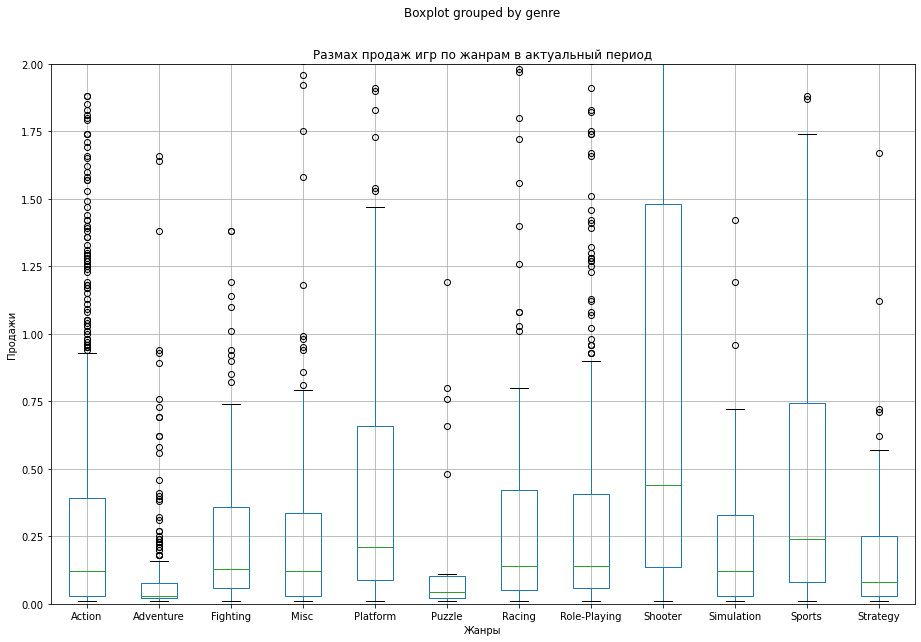

In [57]:
data.boxplot(column=['total_sales'], by='genre', figsize=(15,10))
plt.title('Размах продаж игр по жанрам в актуальный период')
plt.ylim(0,2)
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.show()

Самые высокие средние продажи у шутер и спортивных игр, самые маленькие у жанров приключение и пазлы. У игр жанра экш и ролевых много выбросов с большими продажами, можем предположить, что в этом жанре есть несколько сильно популярных игр.<br> Так же после сравнения с прошлым графиком, можно сделать вывод, что в жанре экш и ролевые производится много игр, что объясняет большие суммарные продажи.

##  Портрет пользователя для каждого региона

Определим сначала распределение в регионах по продажам на платформах.

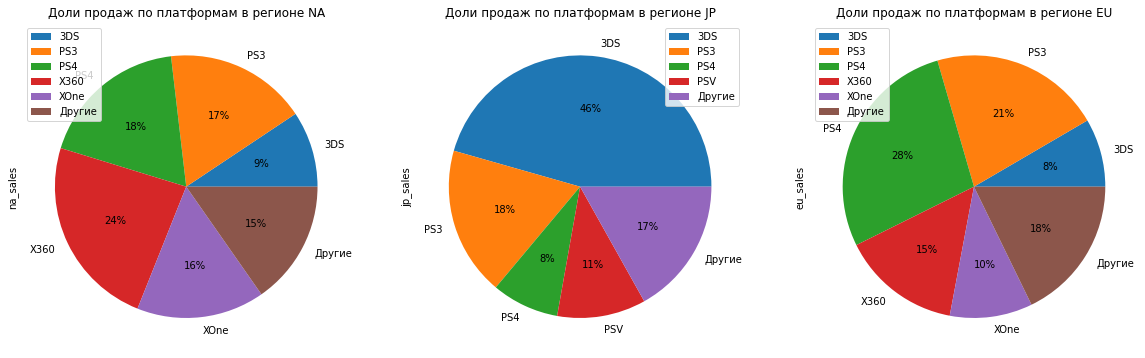

In [58]:
plt.subplots(figsize=(20,10))
regions = ['na', 'jp', 'eu']
for i, region in enumerate(regions):
    column_name = '{}_sales'.format(region)
    current = data.groupby('platform').agg({column_name:'sum'}).reset_index()
    current['perc'] = current[column_name]/current[column_name].sum()
    current.loc[current['perc'] <=0.08, 'platform'] = 'Другие'
    current = current.groupby('platform').agg({column_name:'sum'})
    current.plot(y=column_name, kind='pie',ax= plt.subplot(1, len(regions), i + 1), autopct='%1.0f%%')
    plt.title('Доли продаж по платформам в регионе {}'.format(region.upper()))

В Северной Америке больше всего игр покупают на платформах X360 и PS3. В Японии почти пловину продаж происходит на платформе 3DS. В Европе нет явного фаворита, но платформы PS3 и PS4 продают чуть больше игр. 

Определим доли продаж в регионах по жанрам игр

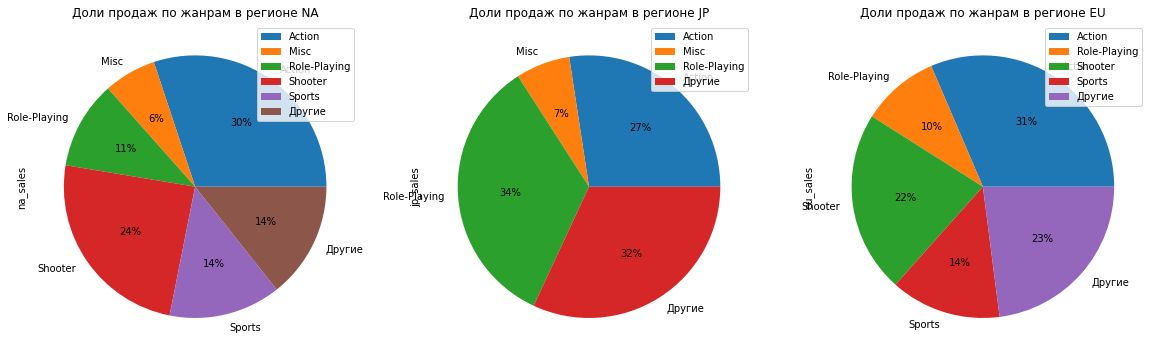

In [59]:
plt.subplots(figsize=(20,10))
regions = ['na', 'jp', 'eu']
for i, region in enumerate(regions):
    column_name = '{}_sales'.format(region)
    current = data.groupby('genre').agg({column_name:'sum'}).reset_index()
    current['perc'] = current[column_name]/current[column_name].sum()
    current.loc[current['perc'] <=0.06, 'genre'] = 'Другие'
    current = current.groupby('genre').agg({column_name:'sum'})
    current.plot(y=column_name, kind='pie',ax= plt.subplot(1, len(regions), i + 1), autopct='%1.0f%%')
    plt.title('Доли продаж по жанрам в регионе {}'.format(region.upper()))

В Северной Америке и Европе распределение продаж игр по жанрам почти идентичны, игры жанра экшн и шутер являются самими популярными.
В Японии же самыми продаваемыми являются ролевые игры, следующии по популярности игры жанра экшн.

Посмотрим продажи в регионах по рейтингам игр

In [60]:
# Для удобства объединим некоторые рейтинги, так как они близки по возрастному ограничению
data.loc[data['rating'] == 'RP', 'rating'] = 'не определен'
data.loc[(data['rating'] == 'K-A') & (data['rating'] == 'EC'), 'rating'] = 'E'
data.loc[data['rating'] == 'AO', 'rating'] = 'M'

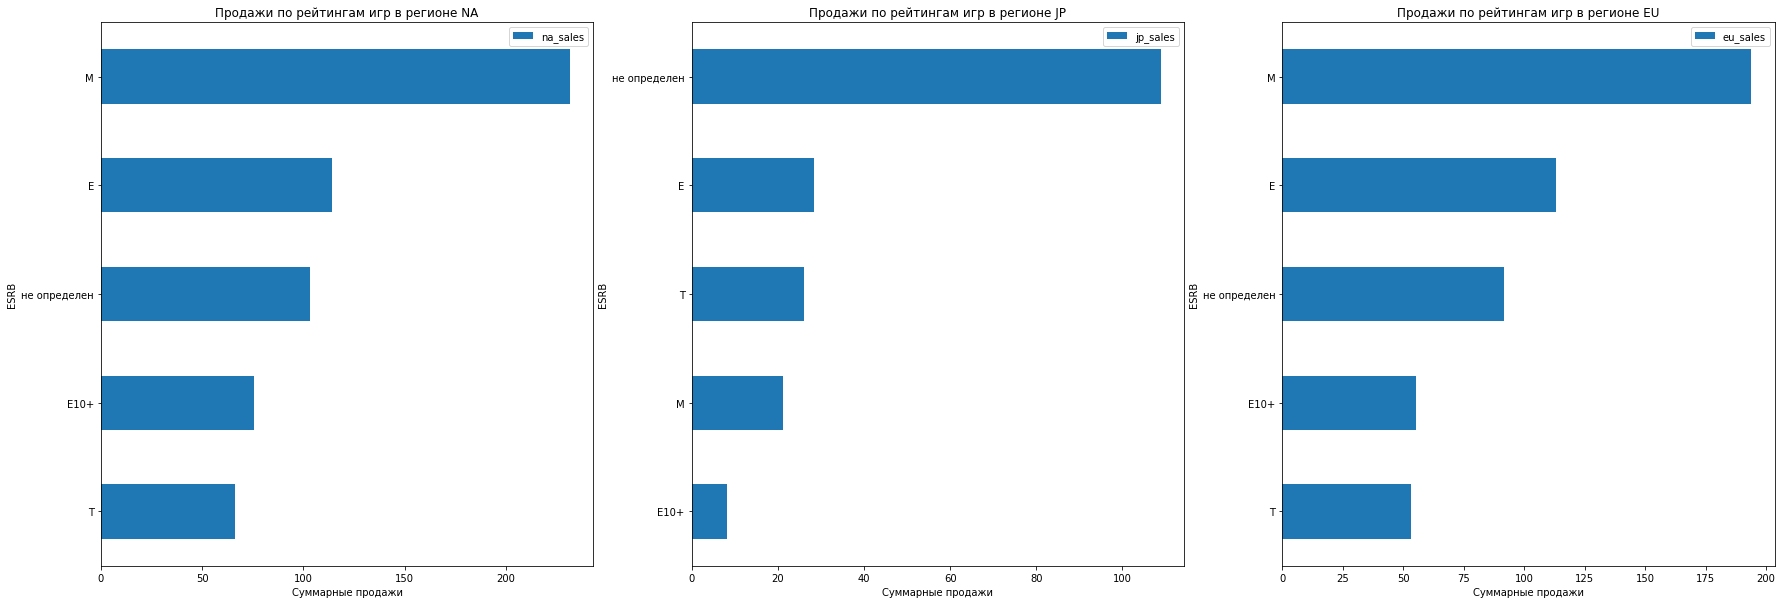

In [61]:
plt.subplots(figsize=(30,10))
regions = ['na', 'jp', 'eu']
for i, region in enumerate(regions):
    column_name = '{}_sales'.format(region)
    current = data.groupby('rating').agg({column_name:'sum'}).reset_index().sort_values(by=column_name)
    current.plot(x='rating', y=column_name, kind='barh',ax= plt.subplot(1, len(regions), i + 1))
    plt.title('Продажи по рейтингам игр в регионе {}'.format(region.upper()))
    plt.xlabel('Суммарные продажи')
    plt.ylabel('ESRB')
plt.show()

В Северной Америке и Европе игры с рейтингом "М" самые популярные. В Японии самый популярный рейтинг не определен, после него идут игры с рейтингом "E" и рейтинг "М" один из самых малопопулярных. 

## Проверка гипотез

В качестве первой нулевой гипотезы возьмем то, что среднее значение пользовательской оценки равна у XOne и PC, а альтернативную, что у XOne больше. 

In [62]:
alpha = 0.05

In [63]:
len(data[data['platform'] == 'XOne'])

247

In [64]:
len(data[data['platform'] == 'PC'])

250

In [65]:
results = ( st.ttest_ind(data.loc[data['platform'] == 'XOne', 'user_score'].dropna(),
                         data.loc[data['platform'] == 'PC', 'user_score'].dropna(), equal_var=False, alternative='greater') )
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 0.2744768982567456
Нет оснований отвергнуть нулевую гипотезу


По результатам теста можем сказать, что нулевая гипотеза не отвергается насчет Xbox One и PC, статистически значимый различий между средним значением пользовательской оценки у XOne и PC нет и среднее выборок близки.

В качестве второй нулевой гипотезы возьмем то, что средние пользовательские рейтинги Экшен-игр и Спортивных игр равны, а альтернативную, что средние рейтинги экшн-игр больше.

In [66]:
results1 = ( st.ttest_ind(data.loc[data['genre'] == 'Action', 'user_score'].dropna()
                          ,data.loc[data['genre'] == 'Sports', 'user_score'].dropna(), equal_var=False, alternative='greater') )
print('p-значение:', results1.pvalue)
if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 2.994729033233709e-20
Отвергаем нулевую гипотезу


По результатам теста можем предположить, что средние рейтинги экшн-игр больше.

# Вывод

В ходе проделанной работы мы определили:<br>
- В среденем жизненный цикл платформы составляет 10 лет.
- Платформы PS4, PS3 и XOne на момент 2016 года являются самыми популярными и в среденем на них продается больше всего игр.
- Платформы PS4 и XOne потенциально будут самыми прибыльными.
- Рейтинги критиков мало влияют на продажи, пользователей еще меньше.
- Самые продаваемые жанры игр это экшн и шутер.
<br>

Составили портрет пользователя для каждого региона:
1.  В Северной Америке большей популярностью пользуются такие платформы, как PS3 и X360. Экшн и шутер игры с рейтингом "М" покупаются чаще всего.
2. В Европе самые популярные платформы это PS4 и PS3. Фавориты в жанрах и рейтингах идентичны Северной Америке.
3. В Японии чуть меньше половины продаж приходится на платформу 3DS. Самыми популярными являются ролевые игры, после них идут экшн-игры.
<br>

Проверили две гипотезы и теперь можем предположить, что:
* средние пользовательские рейтинги на платформах XOne и PC равны.
* средние пользовательские рейтинги экшн-игр больше, чем рейтинги спортивных игр.<br>

В результате мы можем сказать, что в 2017 году самыми прибыльными будут платформы PS4 и XOne, игры жанров экшн и шутер с рейтингом "М".
